In [2]:
import numpy as np
# import seaborn as sns
import pandas as pd
import os.path

import matplotlib.pyplot as plt

import tifffile 
import czifile

from skimage import transform
from scipy import ndimage

import random 
import math

import numpy as np
import seaborn as sns
import pandas as pd
import umap
from joblib import dump, load
import os.path

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.transforms import Bbox

import tifffile 
import czifile

import skimage
from skimage.morphology import remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)

from skimage.morphology import binary_opening, binary_dilation
from skimage.morphology import disk


from scipy import ndimage
from scipy.ndimage import distance_transform_cdt
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# import sys
 
# # adding Folder_2/subfolder to the system path
# sys.path.insert(0, '/mnt/d/lding/UbuntuGitCodes/focal_adhesion_clustering/utils')
 

# function from aicssegmentation tool
from utils.vessel_2d import filament_2d_wrapper
from utils.pre_processing_utils import intensity_normalization


1. make cell shape
2. make fa objects circular ones
3. make fa objects, elipsoids
4. put them in random distance to cell boundary with orienation towards cell edge following a normal distribution


In [17]:
def fa_obj_gen(flag_orient,element, dist_min, dist_max, fa_no,cell_mask, dist_map,local_orientation,):

    # find the indexes(indice) of pixels within the desired location
    indxy = np.where( np.logical_and( dist_map > dist_min, dist_map < dist_max) )

    # random sample from this set
    res = random.sample(range(1, indxy[0].shape[0]), fa_no)

    if(flag_orient==0):
         # init a seed image
        seed_img = np.zeros_like(cell_mask)
        for id_ID in range(fa_no):
            seed_img[indxy[0][res[id_ID]],indxy[1][res[id_ID]]]=1
    
        # conv on the element onto the seed image, altogether
        fa_obj = ndimage.correlate(seed_img, element, mode='constant', origin=-1)
    else:
        # rotation needed
        fa_obj = np.zeros_like(cell_mask)

        for id_ID in range(fa_no):
            seed_img = np.zeros_like(cell_mask)
            seed_img[indxy[0][res[id_ID]],indxy[1][res[id_ID]]]=1
        
            S_rotate = transform.rotate(element, 90 + 180/(np.pi)*local_orientation[indxy[0][res[id_ID]],indxy[1][res[id_ID]]], resize=False, center=None, order=None, mode='constant', cval=0, clip=True)
            model = S_rotate > S_rotate.mean()
            fa_obj_this = ndimage.correlate(seed_img, model, mode='constant', origin=-1)
            fa_obj = fa_obj+fa_obj_this

    return fa_obj

In [22]:
flag_nascent_pere = 1
flag_nascent_band = 1
flag_nascent_any = 1

flag_FA_pere = 1
flag_FA_band = 1

flag_fiber_band = 1


In [ ]:
cell_mask_folder = '/mnt/d/lding/FA/analysis_results/simulation/cell_mask'

cellmask_filenames = [x for x in os.listdir(cell_mask_folder) if os.path.isfile(os.path.join(cell_mask_folder, x)) and ('.tif' in x)]

for cellmask_filenameID in range(10,20):#len(cellmask_filenames)):
    
    filename = cellmask_filenames[cellmask_filenameID]
    cell_mask_img = tifffile.imread(os.path.join(cell_mask_folder,filename))
    cell_mask = cell_mask_img>0
    
    distance_taxicab = distance_transform_cdt(cell_mask, metric="taxicab")
    
    bigger_for_orent_mask = binary_dilation(cell_mask, disk(21))
    bigger_for_orent_distance_taxicab = distance_transform_cdt(bigger_for_orent_mask, metric="taxicab")

    # obtain cell edge orientation based on gradient of the distance map    
    n_v = skimage.filters.sobel_v(bigger_for_orent_distance_taxicab)
    n_h = skimage.filters.sobel_h(bigger_for_orent_distance_taxicab)
    # somehow the gradients are really small, make them reasonable values
    for_plot_max = 5/min(n_v.max(), n_h.max())
    n_v = n_v*for_plot_max
    n_h = n_h*for_plot_max
            
    # convert the directions into orientation angels   
    local_orientation = np.arctan2(n_v,n_h)

    fa_obj = np.zeros_like(cell_mask)
    fa_nascent_obj = np.zeros_like(cell_mask)
    fa_fa_obj = np.zeros_like(cell_mask)
    fa_fiber_obj = np.zeros_like(cell_mask)
    # TYPE 1, NASCENT   

    if flag_nascent_pere > 0:
        nascent_dist = 10
        nascent_no = 100
        nascent_pere_obj = fa_obj_gen(0,disk(5), 0, nascent_dist, nascent_no,cell_mask, distance_taxicab,local_orientation)
        fa_obj = fa_obj + nascent_pere_obj
        fa_nascent_obj = fa_nascent_obj + nascent_pere_obj
    
    if(flag_nascent_band >0):
        nascent_band_dist_min = 20
        nascent_band_dist_max = 50
        nascent_band_no = 100
        nascent_band_obj = fa_obj_gen(0,disk(5), nascent_band_dist_min, nascent_band_dist_max, nascent_band_no,cell_mask, distance_taxicab,local_orientation)
        fa_obj = fa_obj + nascent_band_obj
        fa_nascent_obj = fa_nascent_obj + nascent_band_obj
    
        
    if(flag_nascent_any >0):
        nascent_any_dist_min = 50
        nascent_any_dist_max = 500
        nascent_any_no = 100
        nascent_any_obj = fa_obj_gen(0,disk(5), nascent_any_dist_min, nascent_any_dist_max, nascent_any_no,cell_mask, distance_taxicab,local_orientation)
        fa_obj = fa_obj + nascent_any_obj
        fa_nascent_obj = fa_nascent_obj + nascent_any_obj
    
    if(flag_FA_band >0):
        fa_band_dist_min = 20
        fa_band_dist_max = 200
        fa_band_no = 100
        kk  = disk(25)
        S = kk[::5,:]
        SS = np.zeros_like(disk(25))
        SS[25-5:25+6] = kk[::5,:]

        fa_band_obj = fa_obj_gen(1,SS, fa_band_dist_min, fa_band_dist_max, fa_band_no,cell_mask, distance_taxicab,local_orientation)
        fa_obj = fa_obj + fa_band_obj
        fa_fa_obj = fa_fa_obj + fa_band_obj

    if(flag_FA_pere>0):
        fa_pere_dist_min = 0
        fa_pere_dist_max = 20
        fa_pere_no = 50
        kk  = disk(25)
        S = kk[::5,:]
        SS = np.zeros_like(disk(25))
        SS[25-5:25+6] = kk[::5,:]

        fa_pere_obj = fa_obj_gen(1,SS, fa_pere_dist_min, fa_pere_dist_max, fa_pere_no,cell_mask, distance_taxicab,local_orientation)
        fa_obj = fa_obj + fa_band_obj
        fa_fa_obj = fa_fa_obj + fa_pere_obj

    if(flag_fiber_band >0):
        fa_fiber_dist_min = 250
        fa_fiber_dist_max = 1200
        fa_fiber_no = 50
        kk  = disk(51)
        S = kk[::10,:]
        SS = np.zeros_like(disk(51))
        SS[25-5:25+6] = kk[::10,:]

        fa_fiber_obj = fa_obj_gen(1,SS, fa_fiber_dist_min, fa_fiber_dist_max, fa_fiber_no,cell_mask, distance_taxicab,local_orientation)
        fa_obj = fa_obj + fa_fiber_obj
        fa_fiber_obj = fa_fiber_obj+ fa_fiber_obj
          
    fig = plt.figure(figsize=(9,9), dpi=80)
    plt.imshow(fa_obj,  cmap='gray', vmax=1, vmin=0)

    obj_dir = '/mnt/d/lding/FA/data/synthetic_20240918/'
    tifffile.imwrite(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_nascent_obj_only.tif',fa_nascent_obj)
    tifffile.imwrite(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_mature_obj_only.tif',fa_fa_obj)
    tifffile.imwrite(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fiber_obj_only.tif',fa_fiber_obj)
    tifffile.imwrite(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_obj.tif',fa_obj)
    


In [58]:
def syn_imaging(fa_nascent_obj, cell_mask, int_max,int_bg):
    V1_img = gaussian_filter(fa_nascent_obj.astype(float),5)*(int_max-int_bg)
    background_img = np.random.normal(int_bg, 0.01, fa_nascent_obj.shape)
    output_img = V1_img + background_img
    output_img[output_img<0]=0
    output_img[output_img>1]=1
    return output_img    

In [46]:
def make_npy(fa_nascent_obj, cell_mask, output_img):
    new_img = np.zeros([8,cell_mask.shape[0],cell_mask.shape[1]])
    new_img[0,:,:] = cell_mask
    new_img[1,:,:] = fa_nascent_obj
    new_img[2,:,:] = fa_nascent_obj
    new_img[3,:,:] = cell_mask
    new_img[4,:,:] = cell_mask
    new_img[5,:,:] = cell_mask
    new_img[6,:,:] = output_img
    new_img[7,:,:] = output_img

    return new_img

In [59]:
cell_mask_folder = '/mnt/d/lding/FA/analysis_results/simulation/cell_mask'

cellmask_filenames = [x for x in os.listdir(cell_mask_folder) if os.path.isfile(os.path.join(cell_mask_folder, x)) and ('.tif' in x)]

frame_ind = 0

for cellmask_filenameID in range(0,20):#len(cellmask_filenames)):
    
    filename = cellmask_filenames[cellmask_filenameID]
    cell_mask_img = tifffile.imread(os.path.join(cell_mask_folder,filename))
    cell_mask = cell_mask_img>0

    obj_dir = '/mnt/d/lding/FA/data/synthetic_20240918/'
    if os.path.isfile(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_obj.tif'):
        fa_nascent_obj = tifffile.imread(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_nascent_obj_only.tif') 
        fa_fa_obj = tifffile.imread(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_mature_obj_only.tif')
        fa_fiber_obj = tifffile.imread(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fiber_obj_only.tif')
        fa_obj = tifffile.imread(obj_dir+'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_obj.tif')
    else:
        continue


    for int_max in [0.3,  0.5, 0.7]:
        
        output_img = syn_imaging(fa_obj, cell_mask, int_max, 0.03)
        tifffile.imwrite(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/syn_variable_npy_output_dir', 
                            'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_obj_i'+ '%0.2f' % int_max +'_'+str(frame_ind)+'.tif'),output_img)
        new_img = make_npy(fa_obj, cell_mask, output_img)
        np.save(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/syn_variable_npy_output_dir', 
                            'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_obj_i'+ '%0.2f' % int_max +'_'+str(frame_ind)+'.npy'),new_img) 
        frame_ind = frame_ind+1

        if(cellmask_filenameID<2):
            output_img = syn_imaging(fa_nascent_obj, cell_mask, int_max, 0.03)
            tifffile.imwrite(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/syn_variable_npy_output_dir', 
                            'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_nascent_obj_i'+ '%0.2f' % int_max +'_'+str(frame_ind)+'.tif'),output_img)        
            new_img = make_npy(fa_nascent_obj, cell_mask, output_img)
            np.save(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/syn_variable_npy_output_dir', 
                                'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_nascent_obj_i'+ '%0.2f' % int_max +'_'+str(frame_ind)+'.npy'),new_img) 
            frame_ind = frame_ind+1
            
            output_img = syn_imaging(fa_fa_obj, cell_mask, int_max, 0.03)
            tifffile.imwrite(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/syn_variable_npy_output_dir', 
                            'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_fa_obj_i'+ '%0.2f' % int_max +'_'+str(frame_ind)+'.tif'),output_img)        
            new_img = make_npy(fa_fa_obj, cell_mask, output_img)
            np.save(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/syn_variable_npy_output_dir', 
                                'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_fa_obj_i'+ '%0.2f' % int_max +'_'+str(frame_ind)+'.npy'),new_img) 
            frame_ind = frame_ind+1
            
            output_img = syn_imaging(fa_fiber_obj, cell_mask, int_max, 0.03)
            tifffile.imwrite(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/syn_variable_npy_output_dir', 
                            'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_fiber_obj_i'+ '%0.2f' % int_max +'_'+str(frame_ind)+'.tif'),output_img)        
            new_img = make_npy(fa_fiber_obj, cell_mask, output_img)
            np.save(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/syn_variable_npy_output_dir', 
                                'syn_cellmask'+ '%2d' % cellmask_filenameID +'_fa_fiber_obj_i'+ '%0.2f' % int_max +'_'+str(frame_ind)+'.npy'),new_img) 
            frame_ind = frame_ind+1
            

        


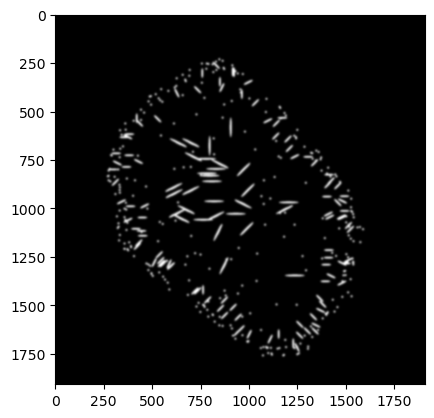

In [47]:
plt.imshow(V1_img,cmap=plt.cm.gray)

In [71]:
new_img = np.zeros([8,cell_mask.shape[0],cell_mask.shape[1]])
new_img[0,:,:] = cell_mask
new_img[1,:,:] = V1_seg
new_img[2,:,:] = V1_seg
new_img[3,:,:] = cell_mask
new_img[4,:,:] = cell_mask
new_img[5,:,:] = cell_mask
new_img[6,:,:] = V1_img
new_img[7,:,:] = V1_img

np.save(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/combined_npy_output_dir', 'V1_img.npy'),new_img) 

In [70]:
cell_mask.shape

(1908, 1908)

In [72]:
new_img = np.zeros([8,cell_mask.shape[0],cell_mask.shape[1]])
new_img[0,:,:] = cell_mask
new_img[1,:,:] = V1_seg
new_img[2,:,:] = V1_seg
new_img[3,:,:] = cell_mask
new_img[4,:,:] = cell_mask
new_img[5,:,:] = cell_mask
new_img[6,:,:] = V1_seg
new_img[7,:,:] = V1_seg

np.save(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/combined_npy_output_dir', 'V1_seg.npy'),new_img) 

In [73]:
new_img = np.zeros([8,cell_mask.shape[0],cell_mask.shape[1]])
new_img[0,:,:] = cell_mask
new_img[1,:,:] = V2_seg
new_img[2,:,:] = V2_seg
new_img[3,:,:] = cell_mask
new_img[4,:,:] = cell_mask
new_img[5,:,:] = cell_mask
new_img[6,:,:] = V2_img
new_img[7,:,:] = V2_img

np.save(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/combined_npy_output_dir', 'V2_img.npy'),new_img) 

In [74]:
new_img = np.zeros([8,cell_mask.shape[0],cell_mask.shape[1]])
new_img[0,:,:] = cell_mask
new_img[1,:,:] = V2_seg
new_img[2,:,:] = V2_seg
new_img[3,:,:] = cell_mask
new_img[4,:,:] = cell_mask
new_img[5,:,:] = cell_mask
new_img[6,:,:] = V2_seg
new_img[7,:,:] = V2_seg

np.save(os.path.join('/mnt/d/lding/FA/analysis_results/simulation/combined_npy_output_dir', 'V2_seg.npy'),new_img) 